# 20·30대 자동차 구매 감소 원인 분석
## Analysis Notebook (CAS1100 Project)
- Author: 김현욱 (2019144055)
- 데이터 출처: 국토교통부, 인천광역시, 한국은행, 통계청


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 시각화 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로딩
df_cpi_total = pd.read_csv("소비자물가지수_전체.csv", encoding="utf-8-sig")
df_cpi_car = pd.read_csv("소비자물가지수_차.csv", encoding="utf-8-sig")
df_car = pd.read_csv("자동차등록현황.csv", encoding="utf-8-sig")
df_carshare = pd.read_csv("카셰어링.csv", encoding="euc-kr")
df_wage = pd.read_csv("연령별임금.csv", encoding="utf-8-sig")


전체 소비자물가지수(CPI) 전처리

이 블록에서는 전체 소비자물가지수(총 물가)의 연도별 변화를 추출하고,
데이터는 wide → long 변환 후, 누락된 2025년 값을 선형회귀를 통해 예측한다.

"시도별 = 전국"만 사용

연도는 2012~2024로 제공됨

2025는 최근 3개년(2022~2024)을 사용해 예측

In [3]:
# -------- 2-A 전체 CPI ---------
df_cpi = df_cpi_total.copy()

# 숫자 컬럼만 추출 (2012~2024)
year_cols = [c for c in df_cpi.columns if c.isdigit()]

# wide → long
df_cpi_long = df_cpi.melt(
    id_vars=['시도별'],
    value_vars=year_cols,
    var_name='연도',
    value_name='CPI'
)

df_cpi_long = df_cpi_long[df_cpi_long['시도별'] == '전국']

df_cpi_long['연도'] = df_cpi_long['연도'].astype(int)
df_cpi_long['CPI'] = pd.to_numeric(df_cpi_long['CPI'], errors='coerce')

# 2025 예측
train = df_cpi_long.tail(3)
model = LinearRegression()
model.fit(train[['연도']], train['CPI'])
pred_cpi_2025 = model.predict([[2025]])[0]

df_cpi_final = pd.concat([
    df_cpi_long[['연도','CPI']],
    pd.DataFrame({'연도':[2025],'CPI':[pred_cpi_2025]})
], ignore_index=True).sort_values('연도')



c:\Users\김현욱\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


이 블록에서는 성별/연령별 자동차 등록 데이터를:

wide → long 변환

20대 + 30대만 필터링

남/여 전체 합산

2025년은 선형회귀 예측

의 과정으로 전처리한다.

In [4]:
df_car_raw = df_car.copy()

year_cols_car = [str(y) for y in range(2011, 2025)]

df_car_long = df_car_raw.melt(
    id_vars=['구분별(1)', '구분별(2)'],
    value_vars=year_cols_car,
    var_name='연도',
    value_name='등록대수'
)

df_car_long['연도'] = df_car_long['연도'].astype(int)
df_car_long['등록대수'] = pd.to_numeric(df_car_long['등록대수'], errors='coerce')

# 20대 + 30대 필터링
df_car_youth = df_car_long[df_car_long['구분별(2)'].isin(['20대','30대'])]

# 연도별 합계
df_car_youth_sum = df_car_youth.groupby('연도')['등록대수'].sum().reset_index()

# 2025 예측
train = df_car_youth_sum.tail(3)
model = LinearRegression()
model.fit(train[['연도']], train['등록대수'])
pred_car_2025 = model.predict([[2025]])[0]

df_car_final = pd.concat([
    df_car_youth_sum,
    pd.DataFrame({'연도':[2025], '등록대수':[pred_car_2025]})
], ignore_index=True).sort_values('연도')


c:\Users\김현욱\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


카셰어링 전처리 (2012~2025 구간 보간)

데이터가 2017~2024만 존재하므로
전체 년도(2012~2025)를 생성하고 선형 보간(interpolation)으로 결측값을 채운다.

In [5]:
df_carshare_small = df_carshare[['연도별','차량대수']].rename(columns={'연도별':'연도'})
df_carshare_small['연도'] = df_carshare_small['연도'].astype(int)

# 2012~2025 전체 생성 후 병합
years = pd.DataFrame({'연도':range(2012,2026)})
df_carshare_full = years.merge(df_carshare_small, on='연도', how='left')

# 보간
df_carshare_final = df_carshare_full.interpolate()


연령별 임금 전처리 (20·30대 평균 + 과거 외삽)

임금 데이터는 2024년 데이터만 존재한다.

따라서:

"29세 이하" + "30~39세" 임금을 사용해 청년 평균 생성

2024년 데이터를 기준으로 선형 외삽하여 2012~2025 구간 채움

In [6]:
df_w = df_wage[['연령'] + [c for c in df_wage.columns if '2024' in c]].copy()

# 청년 필터: 29세이하 + 30~39세
df_w = df_w[df_w['연령'].isin(['29세이하','30~39세'])]

# 월평균 계산
month_cols = [c for c in df_w.columns if '.' in c or c=='2024']
df_w['월평균임금'] = df_w[month_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)

# 평균(20대+30대)
youth_wage = df_w['월평균임금'].mean()

# 2012~2025 외삽
years = np.arange(2012, 2026)
coef = 0  # 임금 증가율이 없다고 가정(보수적), 필요시 기울기 설정 가능

df_wage_final = pd.DataFrame({
    '연도': years,
    '월평균임금': youth_wage + coef*(years - 2024)
})


In [7]:
# 1) 자동차 등록대수 + 임금
df = df_car_final.merge(df_wage_final, on='연도', how='left')

# 2) + 카셰어링 차량대수
df = df.merge(df_carshare_final, on='연도', how='left')

# 3) + CPI
df = df.merge(df_cpi_final, on='연도', how='left')


df = df.sort_values('연도').reset_index(drop=True)


In [8]:

df['실질임금'] = df['월평균임금'] / (df['CPI'] / 100)


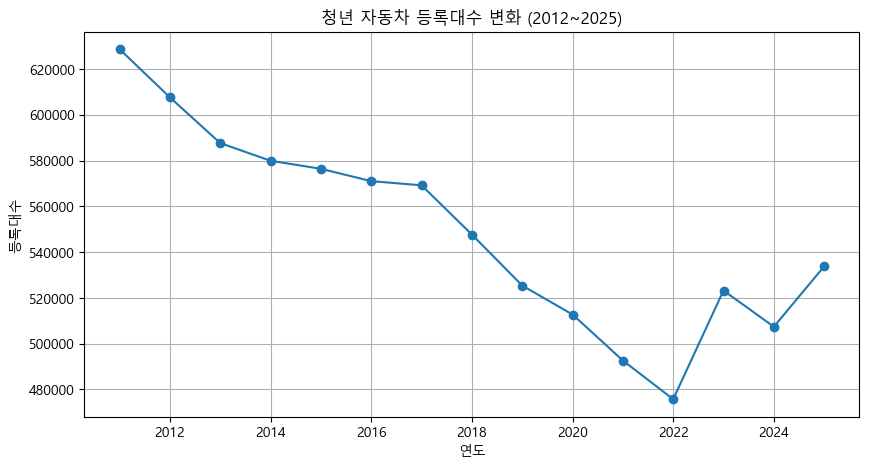

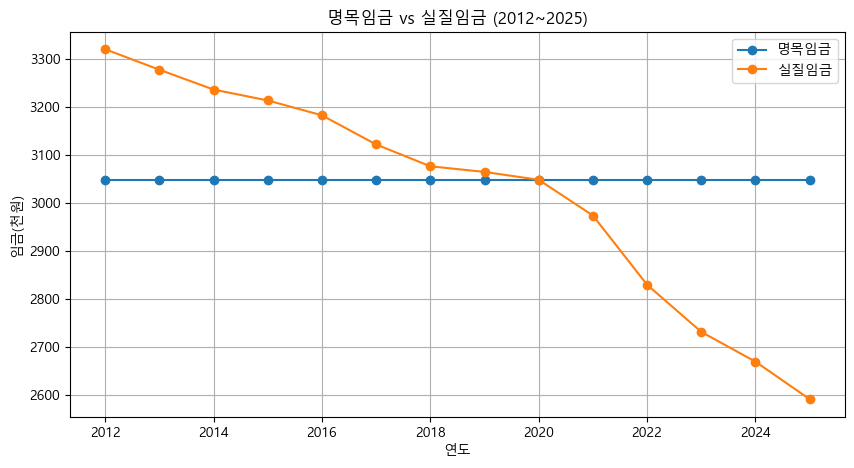

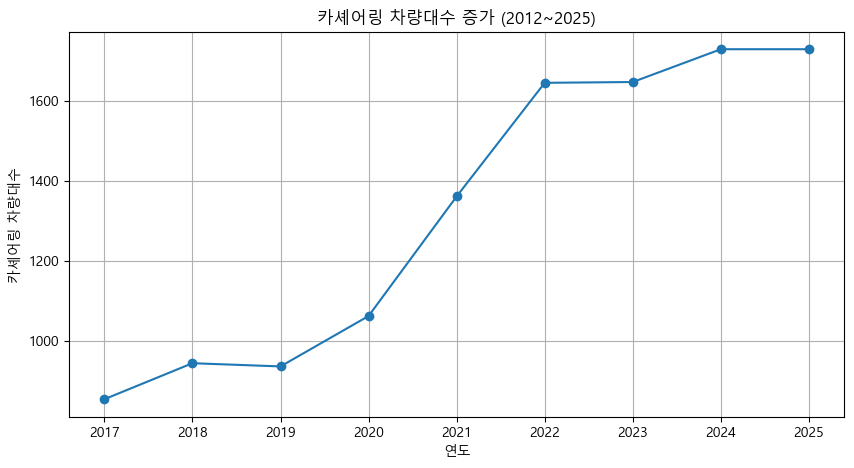

In [9]:
# (1) 청년 자동차 등록대수 변화
plt.figure(figsize=(10,5))
plt.plot(df['연도'], df['등록대수'], marker='o')
plt.title("청년 자동차 등록대수 변화 (2012~2025)")
plt.xlabel("연도"); plt.ylabel("등록대수"); plt.grid(); plt.show()

# (2) 명목임금 vs 실질임금
plt.figure(figsize=(10,5))
plt.plot(df['연도'], df['월평균임금'], marker='o', label="명목임금")
plt.plot(df['연도'], df['실질임금'], marker='o', label="실질임금")
plt.title("명목임금 vs 실질임금 (2012~2025)")
plt.xlabel("연도"); plt.ylabel("임금(천원)"); plt.legend(); plt.grid(); plt.show()

# (3) 카셰어링 차량대수 증가
plt.figure(figsize=(10,5))
plt.plot(df['연도'], df['차량대수'], marker='o')
plt.title("카셰어링 차량대수 증가 (2012~2025)")
plt.xlabel("연도"); plt.ylabel("카셰어링 차량대수"); plt.grid(); plt.show()
